## **Universal Set Up**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import random

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# path = "/content/drive/MyDrive/College/23 - 24/Sem 2 - S24/DS340/DS340 Project - Sahir & Elaine/traffic_Data/DATA"
# labelfile = "/content/drive/MyDrive/College/23 - 24/Sem 2 - S24/DS340/DS340 Project - Sahir & Elaine/labels.csv"
path = "/content/drive/My Drive/DS340 Project - Sahir & Elaine/traffic_Data/DATA"
labelfile = "/content/drive/My Drive/DS340 Project - Sahir & Elaine/labels.csv"

In [36]:
# Hyperparameters part 1
imageDimensions = (32, 32, 3)
testratio = 0.1
validationratio = 0.3
batch_size_val = 15
train_ratio = 1 - (testratio + validationratio)

In [4]:
# process the data
count = 0
Images = []
Classno = []
mylist = os.listdir(path)
print("Total Classes Detected:", len(mylist))
noofclasses = len(mylist)
print("Importing Classes ...")
for count, class_folder in enumerate(mylist):
    mypics = os.listdir(os.path.join(path, class_folder))
    for y in mypics:
        img_path = os.path.join(path, class_folder, y)
        currentImage = cv2.imread(img_path)
        if currentImage is not None:
            currentImage = cv2.resize(currentImage, imageDimensions[:2])
            Images.append(currentImage)
            Classno.append(count)
        else:
            print(f"Image not loaded properly: {img_path}")
    print(f"{count + 1}/{noofclasses}")

Images = np.array(Images)
Classno = np.array(Classno)

Total Classes Detected: 58
Importing Classes ...
1/58
2/58
3/58
4/58
5/58
6/58
7/58
8/58
9/58
10/58
11/58
12/58
13/58
14/58
15/58
16/58
17/58
18/58
19/58
20/58
21/58
22/58
23/58
24/58
25/58
26/58
27/58
28/58
29/58
30/58
31/58
32/58
33/58
34/58
35/58
36/58
37/58
38/58
39/58
40/58
41/58
42/58
43/58
44/58
45/58
46/58
47/58
48/58
49/58
50/58
51/58
52/58
53/58
54/58
55/58
56/58
57/58
58/58


In [37]:
# Hyperparameters part 2
number_of_samples = len(Images)
number_of_training_samples = int(number_of_samples * train_ratio)
steps_per_epoch_val = np.ceil(number_of_training_samples / batch_size_val)
epochs_val = 18

## **Model 1 - Only Data Augmentation**

In [107]:
# Splitting data into 'Train, Validation, Test' sets
X_train, X_test, Y_train, Y_test = train_test_split(Images, Classno, test_size=testratio,shuffle=True)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validationratio)

In [108]:
# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Horizontal shifts
    height_shift_range=0.1,  # Vertical shifts
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10,
)

In [109]:
# Resize the image and make normalize the pixels
def preprocessing(img):
    img = cv2.resize(img, (100, 100))  # Resize image to 100x100
    img = img / 255  # Normalize pixel values to [0, 1]
    return img

# Map the preprocessing function to training and testing images
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [110]:
# Performs one-hot encoding to Y
Y_train = to_categorical(Y_train, noofclasses)
Y_validation = to_categorical(Y_validation, noofclasses)
Y_test = to_categorical(Y_test, noofclasses)

In [49]:
# Test their shapes
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_validation.shape)
print("y_train.shape", Y_train.shape)
print("y_valid.shape",Y_validation.shape)
print("X_test.shape",X_test.shape)
print("Y_test.shape",Y_test.shape)

X_train.shape (2633, 100, 100, 3)
X_valid.shape (1129, 100, 100, 3)
y_train.shape (2633, 58)
y_valid.shape (1129, 58)
X_test.shape (418, 100, 100, 3)
Y_test.shape (418, 58)


In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def mymodel():
    nooffilters = 60
    sizeoffilters1 = (5, 5)
    sizeoffilters2 = (3, 3)
    sizeofpool = (2, 2)
    noofnodes = 500

    model = Sequential()
    model.add(Conv2D(nooffilters, sizeoffilters1, input_shape=(100, 100, 3), activation='relu'))
    model.add(Conv2D(nooffilters, sizeoffilters1, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Conv2D(nooffilters//2, sizeoffilters2, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(noofnodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noofclasses, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model1 = mymodel()
print(model1.summary())

# Training the model
history = model1.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, Y_validation),
    shuffle=True
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 60)        4560      
                                                                 
 conv2d_16 (Conv2D)          (None, 92, 92, 60)        90060     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 46, 46, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 44, 44, 30)        16230     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 22, 22, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 22, 22, 30)       

In [111]:
score = model1.evaluate(X_test, Y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.19053278863430023
Test Accuracy: 0.9330143332481384


## **Model 2 - Grayscale and No Data Augmentation**

In [105]:
# Splitting data into 'Train, Validation, Test' sets
X_train, X_test, Y_train, Y_test = train_test_split(Images, Classno, test_size=testratio,shuffle=True)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validationratio)

In [ ]:
# Adding grayscale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (100, 100))
  return img

# preprocessing w/ grayscale only
def preprocessing_gray(img):
    img = grayscale(img)
    img = img / 255
    return img

# Map the preprocessing function to training and testing images
X_train = np.array(list(map(preprocessing_gray, X_train)))
X_validation = np.array(list(map(preprocessing_gray, X_validation)))
X_test = np.array(list(map(preprocessing_gray, X_test)))

# Reshape images to indicate that they're single channel (grayscale)
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_validation = X_validation.reshape(X_validation.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)

In [ ]:
# Performs one-hot encoding to Y
Y_train = to_categorical(Y_train, noofclasses)
Y_validation = to_categorical(Y_validation, noofclasses)
Y_test = to_categorical(Y_test, noofclasses)

In [ ]:
def mymodel():
    nooffilters = 60
    sizeoffilters1 = (5, 5)
    sizeoffilters2 = (3, 3)
    sizeofpool = (2, 2)
    noofnodes = 500

    model = Sequential()
    model.add(Conv2D(nooffilters, sizeoffilters1, input_shape=(100, 100, 1), activation='relu'))
    model.add(Conv2D(nooffilters, sizeoffilters1, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Conv2D(nooffilters//2, sizeoffilters2, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(noofnodes, activation='relu')) #extrac features
    model.add(Dropout(0.5))
    model.add(Dense(noofclasses, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model2 = mymodel()
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 60)        1560      
                                                                 
 conv2d_4 (Conv2D)           (None, 92, 92, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 46, 46, 60)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 30)        16230     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 30)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 30)       

In [ ]:
history = model2.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size_val,
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, Y_validation),
)


Epoch 1/18
223/223 [==============================] - 9s 14ms/step - loss: 2.7649 - accuracy: 0.3342 - val_loss: 1.0033 - val_accuracy: 0.7454
Epoch 2/18
223/223 [==============================] - 3s 14ms/step - loss: 0.9142 - accuracy: 0.7662 - val_loss: 0.4209 - val_accuracy: 0.8966
Epoch 3/18
223/223 [==============================] - 3s 12ms/step - loss: 0.4301 - accuracy: 0.8808 - val_loss: 0.2218 - val_accuracy: 0.9416
Epoch 4/18
223/223 [==============================] - 3s 11ms/step - loss: 0.2647 - accuracy: 0.9216 - val_loss: 0.1396 - val_accuracy: 0.9629
Epoch 5/18
223/223 [==============================] - 3s 11ms/step - loss: 0.2088 - accuracy: 0.9401 - val_loss: 0.1009 - val_accuracy: 0.9682
Epoch 6/18
223/223 [==============================] - 3s 11ms/step - loss: 0.1380 - accuracy: 0.9566 - val_loss: 0.0916 - val_accuracy: 0.9735
Epoch 7/18
223/223 [==============================] - 3s 11ms/step - loss: 0.1279 - accuracy: 0.9581 - val_loss: 0.0526 - val_accuracy: 0.9788

In [ ]:
score =model2.evaluate(X_test,Y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Test Score: 0.02934371680021286
Test Accuracy: 0.9928229451179504


## **Model 3 - Grayscale and Data Augmentation**

In [84]:
# Splitting data into 'Train, Validation, Test' sets
X_train, X_test, Y_train, Y_test = train_test_split(Images, Classno, test_size=testratio,shuffle=True)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validationratio)

In [85]:
# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Horizontal shifts
    height_shift_range=0.1,  # Vertical shifts
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10,
)

In [86]:
# Adding grayscale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (100, 100))
  return img

# preprocessing w/ grayscale only
def preprocessing_gray(img):
    img = grayscale(img)
    img = img / 255
    return img

# Map the preprocessing function to training and testing images
X_train = np.array(list(map(preprocessing_gray, X_train)))
X_validation = np.array(list(map(preprocessing_gray, X_validation)))
X_test = np.array(list(map(preprocessing_gray, X_test)))

# Reshape images to indicate that they're single channel (grayscale)
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_validation = X_validation.reshape(X_validation.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)

In [87]:
# Performs one-hot encoding to Y
Y_train = to_categorical(Y_train, noofclasses)
Y_validation = to_categorical(Y_validation, noofclasses)
Y_test = to_categorical(Y_test, noofclasses)

In [42]:
def mymodel():
    nooffilters = 60
    sizeoffilters1 = (5, 5)
    sizeoffilters2 = (3, 3)
    sizeofpool = (2, 2)
    noofnodes = 500

    model = Sequential()
    model.add(Conv2D(nooffilters, sizeoffilters1, input_shape=(100, 100, 1), activation='relu'))
    model.add(Conv2D(nooffilters, sizeoffilters1, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Conv2D(nooffilters//2, sizeoffilters2, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(noofnodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noofclasses, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model3 = mymodel()
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 96, 96, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 92, 92, 60)        90060     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 46, 46, 60)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 44, 30)        16230     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 30)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 22, 22, 30)       

In [43]:
history = model3.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, Y_validation),
    shuffle=True
)

Epoch 1/18
168/168 [==============================] - 7s 32ms/step - loss: 3.6559 - accuracy: 0.1058 - val_loss: 3.5068 - val_accuracy: 0.1391
Epoch 2/18
168/168 [==============================] - 4s 24ms/step - loss: 3.4464 - accuracy: 0.1520 - val_loss: 3.0902 - val_accuracy: 0.2329
Epoch 3/18
168/168 [==============================] - 4s 24ms/step - loss: 2.9510 - accuracy: 0.2595 - val_loss: 2.0985 - val_accuracy: 0.4987
Epoch 4/18
168/168 [==============================] - 5s 30ms/step - loss: 2.3322 - accuracy: 0.3928 - val_loss: 1.4824 - val_accuracy: 0.6315
Epoch 5/18
168/168 [==============================] - 4s 26ms/step - loss: 1.8810 - accuracy: 0.4871 - val_loss: 1.3574 - val_accuracy: 0.6599
Epoch 6/18
168/168 [==============================] - 5s 29ms/step - loss: 1.6244 - accuracy: 0.5499 - val_loss: 0.9120 - val_accuracy: 0.7582
Epoch 7/18
168/168 [==============================] - 4s 27ms/step - loss: 1.3854 - accuracy: 0.6076 - val_loss: 0.7743 - val_accuracy: 0.7750

In [88]:
score = model3.evaluate(X_test, Y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.17477300763130188
Test Accuracy: 0.9545454382896423


## **Model 4 - Model with add some Random Noise, Grayscale and Data Augmentation**

In [95]:
# Splitting data into 'Train, Validation, Test' sets
X_train, X_test, Y_train, Y_test = train_test_split(Images, Classno, test_size=testratio,shuffle=True)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validationratio)

In [96]:
# Adding grayscale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (100, 100))
  return img

# preprocessing w/ grayscale only
def preprocessing(img):
    img = grayscale(img)
    img = img / 255
    return img

def add_random_noise(img):
    """Adds random noise to a normalized image."""
    variance = np.random.uniform(0.005, 0.02)
    noise = np.random.normal(0, variance, img.shape)
    img_noise = img + noise
    img_noise = np.clip(img_noise, 0, 1)
    return img_noise

datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Horizontal shifts
    height_shift_range=0.1,  # Vertical shifts
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10,
    preprocessing_function=add_random_noise
)

# Map the preprocessing function to training and testing images
X_train = np.array(list(map(preprocessing_gray, X_train)))
X_validation = np.array(list(map(preprocessing_gray, X_validation)))
X_test = np.array(list(map(preprocessing_gray, X_test)))

# Reshape images to indicate that they're single channel (grayscale)
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_validation = X_validation.reshape(X_validation.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)

In [97]:
# Performs one-hot encoding to Y
Y_train = to_categorical(Y_train, noofclasses)
Y_validation = to_categorical(Y_validation, noofclasses)
Y_test = to_categorical(Y_test, noofclasses)

In [92]:
def mymodel():
    nooffilters = 60
    sizeoffilters1 = (5, 5)
    sizeoffilters2 = (3, 3)
    sizeofpool = (2, 2)
    noofnodes = 500

    model = Sequential()
    model.add(Conv2D(nooffilters, sizeoffilters1, input_shape=(100, 100, 1), activation='relu'))
    model.add(Conv2D(nooffilters, sizeoffilters1, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Conv2D(nooffilters//2, sizeoffilters2, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(noofnodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noofclasses, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model4 = mymodel()
print(model4.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 96, 96, 60)        1560      
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 60)        90060     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 46, 46, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 44, 44, 30)        16230     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 22, 22, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 30)       

In [93]:
history = model4.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, Y_validation),
    shuffle=True
)

Epoch 1/18
168/168 [==============================] - 7s 31ms/step - loss: 3.6055 - accuracy: 0.1186 - val_loss: 3.3671 - val_accuracy: 0.1860
Epoch 2/18
168/168 [==============================] - 5s 29ms/step - loss: 3.1175 - accuracy: 0.2292 - val_loss: 2.4445 - val_accuracy: 0.3933
Epoch 3/18
168/168 [==============================] - 5s 31ms/step - loss: 2.5240 - accuracy: 0.3414 - val_loss: 1.8635 - val_accuracy: 0.5580
Epoch 4/18
168/168 [==============================] - 5s 30ms/step - loss: 2.0718 - accuracy: 0.4405 - val_loss: 1.3027 - val_accuracy: 0.6652
Epoch 5/18
168/168 [==============================] - 6s 37ms/step - loss: 1.7331 - accuracy: 0.5177 - val_loss: 1.0605 - val_accuracy: 0.7166
Epoch 6/18
168/168 [==============================] - 5s 31ms/step - loss: 1.4813 - accuracy: 0.5953 - val_loss: 0.8874 - val_accuracy: 0.7679
Epoch 7/18
168/168 [==============================] - 6s 36ms/step - loss: 1.3092 - accuracy: 0.6147 - val_loss: 0.7695 - val_accuracy: 0.7812

In [98]:
score = model4.evaluate(X_test, Y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.23163726925849915
Test Accuracy: 0.9306219816207886


## **Model 5 - Model with add some Random Noise, Grayscale, Data Augmentation and autofill**

In [154]:
# Splitting data into 'Train, Validation, Test' sets
X_train, X_test, Y_train, Y_test = train_test_split(Images, Classno, test_size=testratio,shuffle=True)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validationratio)

In [155]:
# Adding grayscale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (100, 100))
  return img

# preprocessing w/ grayscale only
def preprocessing(img):
    img = grayscale(img)
    img = img / 255
    return img

def add_random_noise(img):
    """Adds random noise to a normalized image."""
    variance = np.random.uniform(0.005, 0.02)  # Reduced and adjusted variance
    noise = np.random.normal(0, variance, img.shape)
    img_noise = img + noise
    img_noise = np.clip(img_noise, 0, 1)  # Ensure pixel values remain valid
    return img_noise

datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Horizontal shifts
    height_shift_range=0.1,  # Vertical shifts
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10,
    fill_mode='nearest',  # Strategy for filling newly created pixels
    preprocessing_function=add_random_noise
)

# Map the preprocessing function to training and testing images
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Reshape images to indicate that they're single channel (grayscale)
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_validation = X_validation.reshape(X_validation.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)

In [156]:
# Performs one-hot encoding to Y
Y_train = to_categorical(Y_train, noofclasses)
Y_validation = to_categorical(Y_validation, noofclasses)
Y_test = to_categorical(Y_test, noofclasses)

In [157]:
def mymodel():
    nooffilters = 60
    sizeoffilters1 = (5, 5)
    sizeoffilters2 = (3, 3)
    sizeofpool = (2, 2)
    noofnodes = 500

    model = Sequential()
    model.add(Conv2D(nooffilters, sizeoffilters1, input_shape=(100, 100, 1), activation='relu'))
    model.add(Conv2D(nooffilters, sizeoffilters1, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Conv2D(nooffilters//2, sizeoffilters2, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(noofnodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noofclasses, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model5 = mymodel()
print(model5.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 96, 96, 60)        1560      
                                                                 
 conv2d_22 (Conv2D)          (None, 92, 92, 60)        90060     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 46, 46, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 44, 44, 30)        16230     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 22, 22, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 22, 22, 30)       

In [158]:
history = model5.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, Y_validation),
    shuffle=True
)

Epoch 1/18
168/168 [==============================] - 7s 34ms/step - loss: 3.6592 - accuracy: 0.1138 - val_loss: 3.4339 - val_accuracy: 0.1267
Epoch 2/18
168/168 [==============================] - 7s 39ms/step - loss: 3.3356 - accuracy: 0.1791 - val_loss: 2.7177 - val_accuracy: 0.3198
Epoch 3/18
168/168 [==============================] - 5s 31ms/step - loss: 2.7015 - accuracy: 0.2988 - val_loss: 1.7602 - val_accuracy: 0.5589
Epoch 4/18
168/168 [==============================] - 6s 34ms/step - loss: 2.2081 - accuracy: 0.4087 - val_loss: 1.2515 - val_accuracy: 0.6767
Epoch 5/18
168/168 [==============================] - 6s 37ms/step - loss: 1.8771 - accuracy: 0.4922 - val_loss: 1.0873 - val_accuracy: 0.7104
Epoch 6/18
168/168 [==============================] - 5s 29ms/step - loss: 1.6481 - accuracy: 0.5404 - val_loss: 0.8527 - val_accuracy: 0.7777
Epoch 7/18
168/168 [==============================] - 6s 35ms/step - loss: 1.4286 - accuracy: 0.5929 - val_loss: 0.7895 - val_accuracy: 0.7750

In [159]:
score = model5.evaluate(X_test, Y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.31740736961364746
Test Accuracy: 0.9186602830886841


## **Transfer Learning**

In [114]:
# Importing the paths
train_data_path = "/content/drive/My Drive/DS340 Project - Sahir & Elaine/traffic_Data/DATA"
test_data_path = "/content/drive/My Drive/DS340 Project - Sahir & Elaine/traffic_Data/TEST"

# train_data_path = "/content/drive/MyDrive/College/23 - 24/Sem 2 - S24/DS340/DS340 Project - Sahir & Elaine/traffic_Data/DATA"
# test_data_path = "/content/drive/MyDrive/College/23 - 24/Sem 2 - S24/DS340/DS340 Project - Sahir & Elaine/traffic_Data/TEST"



import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freeze the layers of the base model and add custom layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(58, activation='softmax')(x)

# Create the new model
model_transfer = Model(inputs=base_model.input, outputs=output_layer)
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Prepare the data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Train the model
history = model_transfer.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=valid_generator,
    validation_steps=np.ceil(valid_generator.samples / valid_generator.batch_size),
    epochs=10
)



Found 3368 images belonging to 58 classes.
Found 812 images belonging to 58 classes.
Epoch 1/10
106/106 [==============================] - 71s 656ms/step - loss: 1.8281 - accuracy: 0.7111 - val_loss: 0.3239 - val_accuracy: 0.9163
Epoch 2/10
106/106 [==============================] - 69s 649ms/step - loss: 0.2031 - accuracy: 0.9439 - val_loss: 0.1395 - val_accuracy: 0.9557
Epoch 3/10
106/106 [==============================] - 71s 671ms/step - loss: 0.1221 - accuracy: 0.9664 - val_loss: 0.0735 - val_accuracy: 0.9828
Epoch 4/10
106/106 [==============================] - 71s 670ms/step - loss: 0.0885 - accuracy: 0.9733 - val_loss: 0.1026 - val_accuracy: 0.9643
Epoch 5/10
106/106 [==============================] - 70s 660ms/step - loss: 0.0396 - accuracy: 0.9890 - val_loss: 0.0247 - val_accuracy: 0.9951
Epoch 6/10
106/106 [==============================] - 68s 643ms/step - loss: 0.0302 - accuracy: 0.9935 - val_loss: 0.0443 - val_accuracy: 0.9840
Epoch 7/10
106/106 [=========================

**Some tests and results**

1/1 [==============================] - 0s 30ms/step


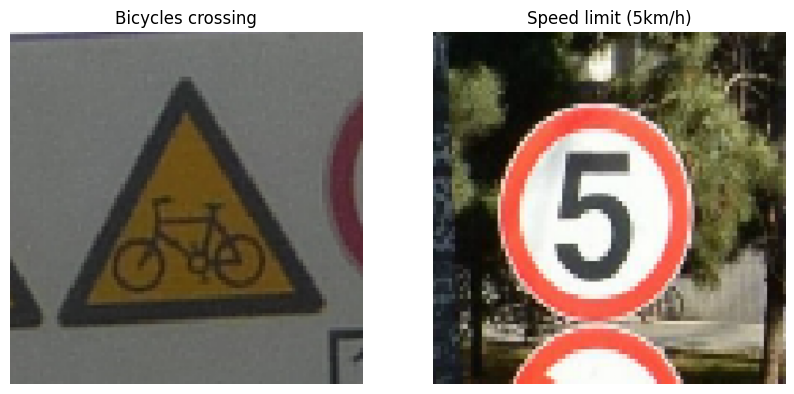

In [153]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import pandas as pd

# Load the class labels
labels_path = "/content/drive/My Drive/DS340 Project - Sahir & Elaine/labels.csv"
labels_df = pd.read_csv(labels_path)
class_labels = pd.Series(labels_df.Name.values, index=labels_df.ClassId).to_dict()

image_paths = [
    '/content/drive/MyDrive/DS340 Project - Sahir & Elaine/traffic_Data/DATA/36/036_0001.png',
    '/content/drive/MyDrive/DS340 Project - Sahir & Elaine/traffic_Data/TEST/000_0003_j.png',
]

# Load and preprocess the images
test_images = []
for img_path in image_paths:
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    test_images.append(img_array)

# Convert to a numpy array and scale the images
test_images = np.array(test_images) / 255.0

# Make predictions using the model
predictions = model_transfer.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Convert predicted class indices to labels
predicted_labels = [class_labels[idx] for idx in predicted_classes]

import matplotlib.pyplot as plt

def display_test_images_with_predictions(images, labels):
    plt.figure(figsize=(10, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = plt.subplot(1, len(images), i + 1)
        if img.dtype == np.float32:
            plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.show()

display_test_images_with_predictions(test_images, predicted_labels)
